In [10]:
# Import necessary libraries
import os
import tarfile
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, Input, UpSampling2D
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping


In [2]:
# Define dataset URL
dataset_url = "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420938130-1629953152/screw.tar.xz"

# Define dataset path
dataset_filename = "screw.tar.xz"

# Download dataset
!wget -O {dataset_filename} "{dataset_url}"

# Create extraction folder
extracted_folder = "screw"

# Extract dataset
with tarfile.open(dataset_filename, "r:xz") as tar:
    tar.extractall(extracted_folder)

# Verify extraction
print("✅ Dataset extracted successfully!")
print("📂 Contents of the dataset directory:")
!ls screw

--2025-04-17 20:19:43--  https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420938130-1629953152/screw.tar.xz
Resolving www.mydrive.ch (www.mydrive.ch)... 91.214.169.64
Connecting to www.mydrive.ch (www.mydrive.ch)|91.214.169.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 195344332 (186M) [application/x-xz]
Saving to: ‘screw.tar.xz’

screw.tar.xz        100%[===================>] 186.29M  22.3MB/s    in 9.2s    

2025-04-17 20:19:53 (20.3 MB/s) - ‘screw.tar.xz’ saved [195344332/195344332]

✅ Dataset extracted successfully!
📂 Contents of the dataset directory:
screw


In [5]:
import os

def count_images_in_folder(folder_path):
    count = 0
    for root, _, files in os.walk(folder_path):
        count += len([f for f in files if f.endswith(".png")])
    return count

# Set the root path
dataset_root = "screw/screw"

# Count train images
train_good_path = os.path.join(dataset_root, "train/good")
train_count = count_images_in_folder(train_good_path)
print(f" Number of training images (good only): {train_count}")

# Count test images per category
test_dir = os.path.join(dataset_root, "test")
test_categories = os.listdir(test_dir)
print("\n Test set distribution:")
for category in sorted(test_categories):
    category_path = os.path.join(test_dir, category)
    count = count_images_in_folder(category_path)
    print(f"   - {category}: {count} images")

 Number of training images (good only): 320

 Test set distribution:
   - good: 41 images
   - manipulated_front: 24 images
   - scratch_head: 24 images
   - scratch_neck: 25 images
   - thread_side: 23 images
   - thread_top: 23 images


# Preprocess training images (good)

In [6]:

# Parameters
img_size = (128, 128)  # Smaller than 224x224 for faster training
train_dir = "screw/screw/train/good"

# Load all training images (good only)
def load_images_from_folder(folder_path, size):
    images = []
    for filename in sorted(os.listdir(folder_path)):
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        if img is not None:
            img = cv2.resize(img, size)
            img = img.astype("float32") / 255.0  # Normalize
            images.append(img)
    return np.array(images)

# Load training data
train_images = load_images_from_folder(train_dir, img_size)
print(f" Loaded {len(train_images)} good training images with shape: {train_images.shape}")

✅ Loaded 320 good training images with shape: (320, 128, 128, 3)


In [11]:


# Define the input
input_img = Input(shape=(128, 128, 3))

# Encoder
x = Conv2D(32, (3, 3), activation='relu', padding='same',
           kernel_regularizer=regularizers.l2(1e-4))(input_img)
x = MaxPool2D((2, 2), padding='same')(x)
x = Dropout(0.3)(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same',
           kernel_regularizer=regularizers.l2(1e-4))(x)
x = MaxPool2D((2, 2), padding='same')(x)
x = Dropout(0.3)(x)

# Decoder
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)

# Output layer (reconstructed image)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

# Autoencoder model
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 64, 64, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_3 (UpSampling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 128, 128, 3)    │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,651 (295.51 KB)

 Trainable params: 75,651 (295.51 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:

# Compile the model
autoencoder.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='mse'  # Mean Squared Error for pixel-wise difference
)

# Early stopping to avoid overfitting
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Train the model
history = autoencoder.fit(
    train_images, train_images,  # input = output for autoencoders
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    shuffle=True,
    callbacks=[early_stop]
)

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - loss: 0.0696 - val_loss: 0.0528
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - loss: 0.0468 - val_loss: 0.0413
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - loss: 0.0306 - val_loss: 0.0270
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - loss: 0.0220 - val_loss: 0.0213
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - loss: 0.0212 - val_loss: 0.0235
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - loss: 0.0197 - val_loss: 0.0261
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - loss: 0.0194 - val_loss: 0.0256
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - loss: 0.0192 - val_loss: 0.0246
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - loss: 0.0189 - val_loss: 0.0246


In [13]:
# Directory containing all test images (good + defects)
test_dir = "screw/screw/test"

# Load test images from all subfolders
def load_test_images(root_folder, size):
    images = []
    labels = []
    class_names = os.listdir(root_folder)
    for class_name in class_names:
        class_path = os.path.join(root_folder, class_name)
        for filename in sorted(os.listdir(class_path)):
            img_path = os.path.join(class_path, filename)
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)
            if img is not None:
                img = cv2.resize(img, size)
                img = img.astype("float32") / 255.0
                images.append(img)
                labels.append(0 if class_name == "good" else 1)  # 0 = good, 1 = defect
    return np.array(images), np.array(labels)

# Load and preview
test_images, test_labels = load_test_images(test_dir, img_size)
print(f"Loaded {len(test_images)} test images with shape: {test_images.shape}")

Loaded 160 test images with shape: (160, 128, 128, 3)


In [14]:
# Reconstruct test images
reconstructed = autoencoder.predict(test_images)

5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 690ms/step


In [15]:
# Compute mean squared error per image
reconstruction_errors = np.mean(np.square(test_images - reconstructed), axis=(1, 2, 3))

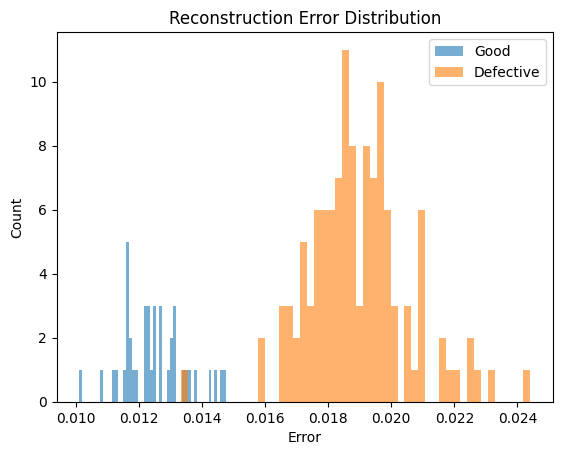

In [16]:
import matplotlib.pyplot as plt

# Plot error distribution
plt.hist(reconstruction_errors[test_labels == 0], bins=50, alpha=0.6, label='Good')
plt.hist(reconstruction_errors[test_labels == 1], bins=50, alpha=0.6, label='Defective')
plt.title("Reconstruction Error Distribution")
plt.xlabel("Error")
plt.ylabel("Count")
plt.legend()
plt.show()

In [17]:
# Set threshold based on max error from good images
threshold = np.max(reconstruction_errors[test_labels == 0])
print(f"Suggested threshold: {threshold:.4f}")

Suggested threshold: 0.0148


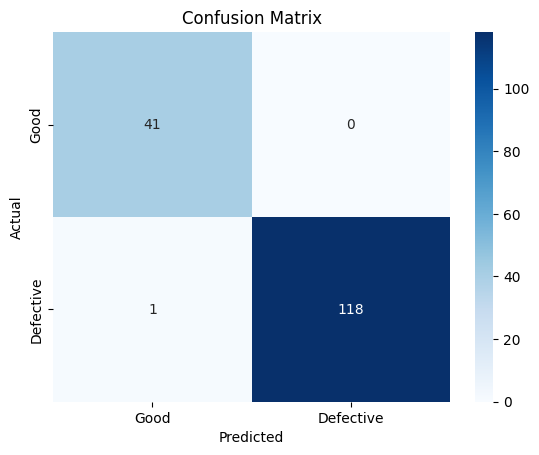

Classification Report:
               precision    recall  f1-score   support

        Good       0.98      1.00      0.99        41
   Defective       1.00      0.99      1.00       119

    accuracy                           0.99       160
   macro avg       0.99      1.00      0.99       160
weighted avg       0.99      0.99      0.99       160



In [18]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Predict anomalies
y_pred = (reconstruction_errors > threshold).astype(int)

# Confusion matrix
cm = confusion_matrix(test_labels, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Good", "Defective"], yticklabels=["Good", "Defective"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification report
print("Classification Report:\n", classification_report(test_labels, y_pred, target_names=["Good", "Defective"]))

In [19]:
# Save the entire model (architecture + weights + optimizer config)
autoencoder.save("autoencoder_model.h5")